## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../multiscale_HiTS/src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
import ResNet as tnet

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils_MrCAE import *


## Simulation 

In [2]:
# #make amd save data
# # params
# w0 = 0.5
# w1 = 4.0
# sigma0 = 10.0
# sigma1 = 0.25

# # define two modes
# def phi1(x, y, t):
#     return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

# def phi2(x, y, t):
#     return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

# # mesh grids
# x = np.linspace(-5, 5, 127)
# y = np.linspace(-5, 5, 127)
# t = np.linspace(0, 40*np.pi, 500)
# xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

# # Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
# # print(Phi.shape)
# # plt.plot(Phi[0,0])


# # # generate data shape (100,500,127,127)
# n_train = 500
# n_val = 100
# train_data = np.zeros((n_train,500,127,127))
# for i in tqdm(range(n_train)):
#     #t start somewhere between zero and 2 pi
#     start_t = np.random.rand(1) * 2*np.pi
# #     print(start_t)
#     t = np.linspace(0, 40*np.pi, 500) + start_t
#     xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
#     Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
#     scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
#     train_data[i] = scaled_Phi.T
    
# print("saving...")
# np.save('../data/toy1_train_data.npy',train_data)
# val_data = np.zeros((n_val,500,127,127))
# for i in tqdm(range(n_val)):
#     #t start somewhere between zero and 2 pi
#     start_t = np.random.rand(1) * 2*np.pi
#     t = np.linspace(0, 40*np.pi, 500) + start_t
#     xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
#     Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
#     scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
#     val_data[i] = scaled_Phi.T
    
# print("saving ...")
# np.save('../data/toy1_val_data.npy',val_data)
# # scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
# # print(Phi.shape)


# # #normalize 

# # train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
# # print(train_data.shape)
# # val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())

# # np.save(data_path, scaled_Phi.T)

# # np.save('../data/toy1_train_data.npy',train_data)
# # np.save('../data/toy1_val_data.npy',val_data)

## MrCAE

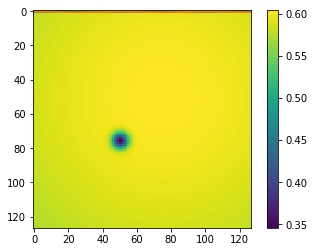

In [3]:
#load data

train_data = np.load('../data/toy1_train_data.npy')
val_data = np.load('../data/toy1_val_data.npy')

plt.plot(train_data[0,:,0,0])
plt.plot(val_data[0,:,0,0])

plt.imshow(train_data[0,0])
plt.colorbar()

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [4]:
# init model & load data
# print(train_data.shape)
data_path = '../data/toy1.npy'
# np.save(data_path, train_data[:,0])
# data_path = '../data/toy1_train_data.npy'
model_path = '../model/toy1_space/'
result_path = '../result/toy1_space/' 

# data = np.load(data_path)
# print(data.shape)

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [5]:
# print(dataset.train_data.shape)

In [6]:
# training in space
archs = [[1,2],[1,2],[1,3]]#,3,4],[1,2,3,4],[1,3,5,7]]
tols = [ 0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)

*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/2000]
[training set] local: 0.0019/0.0302/0.0160, global: 0.0019/0.0302/0.0160
[validation set] local: 0.0019/0.0303/0.0161, global: 0.0018/0.0303/0.0161
epoch [200/2000]:
[training set] local: 0.0006/0.0250/0.0128, global: 0.0006/0.0251/0.0128
[validation set] local: 0.0006/0.0256/0.0131, global: 0.0006/0.0257/0.0132
epoch [400/2000]:
[training set] local: 0.0005/0.0129/0.0067, global: 0.0005/0.0148/0.0077
[validation set] local: 0.0005/0.0133/0.0069, global: 0.0005/0.0153/0.0079
epoch [600/2000]:
[training set] local: 0.0001/0.0047/0.0024, global: 0.0001/0.0089/0.0045
[validation set] local: 0.0001/0.0047/0.0024, global: 0.0001/0.0089/0.0045
epoch [800/2000]:
[training set] local: 0.0000/0.0032/0.0016, global: 0.0000/0.0076/

KeyboardInterrupt: 

In [7]:
# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_0_16
model_L0_0_2
model_L0_0_4
model_L0_0_8
model_L0_1
model_L0_1_2
model_L0_1_4
model_L0_1_8
model_L1_0
model_L1_1
model_L2_0


In [8]:
#define some functions
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
    
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
#         print('L{}_Conv_{}'.format(level, i))
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
            
            
        else:
            i =self.n_filter_groups_each_level['0'] -1
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

torch.Size([500, 1, 15, 15])


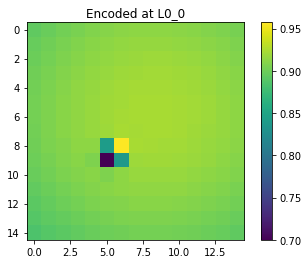

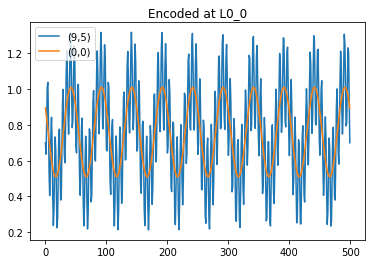

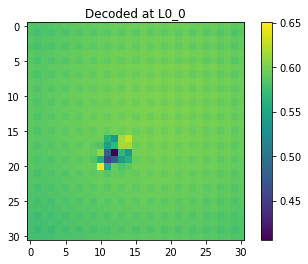

train_data_this =  torch.Size([500, 1, 31, 31])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


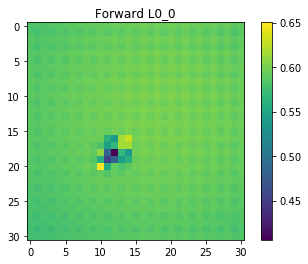

torch.Size([500, 1, 31, 31])


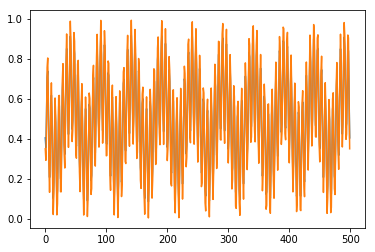

torch.Size([500, 31, 31])


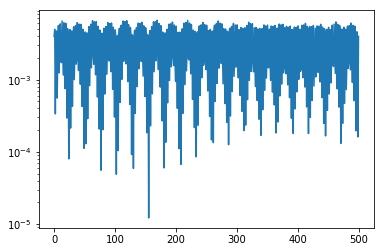

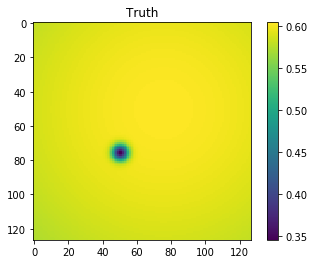

In [19]:
model = models_space['model_L0_0']

train_data_this = obtain_data_at_current_level(torch.tensor(train_data[0]).unsqueeze(1).float(), 0,3)

encoded = encode(model, train_data_this.to('cuda').float(), 0)
print(encoded.shape)
plt.imshow(encoded[0,0].cpu().detach().numpy())
plt.title("Encoded at L0_0")
plt.colorbar()
plt.show()


plt.plot(encoded[:,0,9,5].cpu().detach().numpy(), label = "(9,5)")
plt.plot(encoded[:,0,0,0].cpu().detach().numpy(), label = "(0,0)")
plt.title("Encoded at L0_0")
plt.legend()
plt.show()

decoded = decode(model, encoded, 0)
plt.imshow(decoded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.title("Decoded at L0_0")
plt.show()

print("train_data_this = ", train_data_this.shape)
forward,_,_,_ = model(torch.tensor(train_data_this[:,0]).unsqueeze(1).to('cuda').float(), 0)
plt.imshow(forward[0,0].cpu().detach().numpy())
plt.title("Forward L0_0")
plt.colorbar()
plt.show()

print(forward.shape)
plt.plot(forward[:,0,18,12].cpu().detach().numpy())
plt.plot(train_data_this[:,0,18,12].cpu().detach().numpy())
plt.show()

print(train_data_this[:,0].shape)
x = train_data_this[:,0].cpu().detach().numpy()
y = forward[:,0].cpu().detach().numpy()
# print(x.shape)
# print(y.shape)
# print((np.mean((x-y)**2, axis = (1,2))))
plt.semilogy(np.max((x-y)**2, axis = (1,2)))
plt.show()

plt.imshow(train_data[0,0])
plt.title("Truth")
plt.colorbar()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

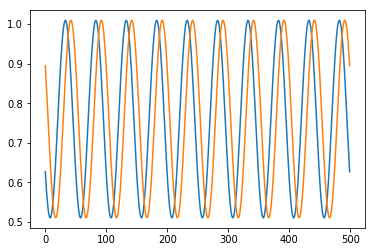

In [9]:
# #encode the data 
model = models_space['model_L0_0']
n_train, n_timesteps, _,_ = train_data.shape
train_encoded = torch.zeros((n_train, n_timesteps, 15,15))
val_encoded = torch.zeros((len(val_data), n_timesteps, 15,15))
data = torch.tensor(train_data).unsqueeze(2).float()

val_data_layer0 = torch.zeros((len(val_data), n_timesteps, 31,31))
train_data_layer0 = torch.zeros((len(train_data), n_timesteps, 31,31))
for i in tqdm(range(len(train_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
    train_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    train_encoded[i] = encoded[:,0]

data = torch.tensor(val_data).unsqueeze(2).float()
for i in tqdm(range(len(val_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
#     print(data_this.shape)
    val_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    val_encoded[i] = encoded[:,0]
    
#plot to make sure they are relatively the same 
plt.plot(val_encoded[1,:,0,0].cpu().detach().numpy())

plt.plot(train_encoded[0,:,0,0].cpu().detach().numpy())

In [11]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
step_size = 8
dt=1
n_forward = 5
arch = [225, 225*2, 225*2, 225*2, 225]
batch_size = 500
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_0_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

dataset = utils.DataSet(train_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_0_8.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

epoch 1000, training loss 0.002704095095396042, validation loss 0.002925537759438157
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.002905398141592741, validation loss 0.0031400281004607677
epoch 3000, training loss 0.001497932942584157, validation loss 0.0014610266080126166
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.0018967855721712112, validation loss 0.001969824777916074
epoch 5000, training loss 0.0012906043557450175, validation loss 0.00136063143145293
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.0010246429592370987, validation loss 0.0010703414445742965
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.0008533534128218889, validation loss 0.0009028250351548195
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.001635724096558988, validation loss 0.001511450158432126
epoch 9000, training loss 0.000868920877110213, validation loss 0.0009292819886468351
epoch 10000, training loss 0.0005387267447076738, va

KeyboardInterrupt: 

In [12]:
# load models
step_sizes = [8]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_0_8.pt


torch.Size([100, 500, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


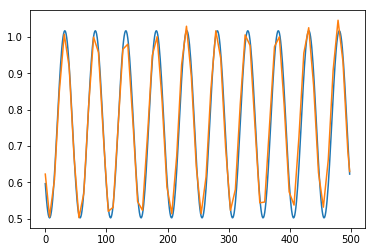

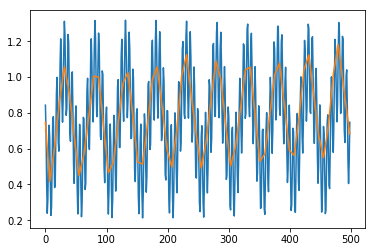

No handles with labels found to put in legend.


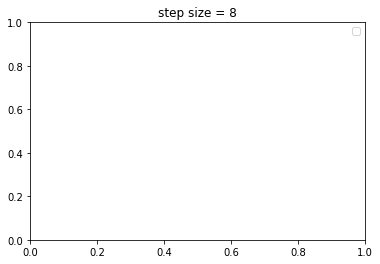

(array([-3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. ]),
 <a list of 10 Text yticklabel objects>)

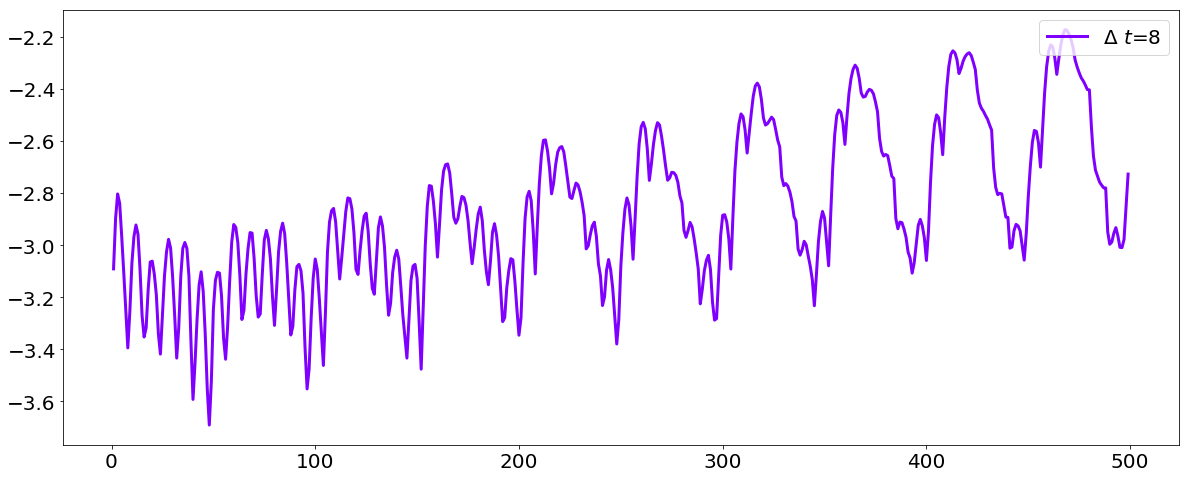

In [37]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = 499
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().is_cuda)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1))
    for i in [1,140]:#range(1):
        
        plt.plot(test_data[1, 1:, i].detach().numpy(),label="Truth")
        plt.plot(y_preds[1,:,i], label="predicted")
        x = y_preds[1,::model.step_size,i]
        plt.show()
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.legend()
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

torch.Size([100, 499, 225])
tensor(210)


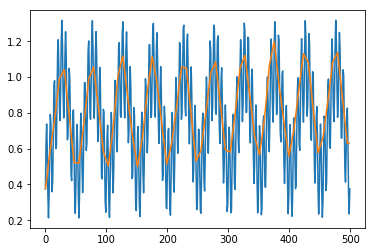

In [14]:
print(y_preds.shape)
print(np.argmax(y_preds[0,0]))
plt.plot(test_data[0,:,140].cpu().detach().numpy())
plt.plot(y_preds[0,:,140])

In [15]:
# model = models_time[0]
#get encoded versions of validation adn training
print(torch.tensor(test_data[:, 0, :]).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
print(test_data.shape)
print(y_preds.shape)
encoded_t1_val = torch.reshape(y_preds, (100,499,15,15))
# print(encoded_t1.shape)
print(val_encoded.shape)

print(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=2).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=1).float(), n_steps=n_steps)
print(y_preds.shape)
encoded_t1_train = torch.reshape(y_preds, (len(y_preds),n_steps,15,15))
print(encoded_t1_train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


torch.Size([100, 225])
torch.Size([100, 500, 225])
torch.Size([100, 499, 225])
torch.Size([100, 500, 15, 15])
torch.Size([500, 15, 15])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


torch.Size([500, 499, 225])
torch.Size([500, 499, 15, 15])


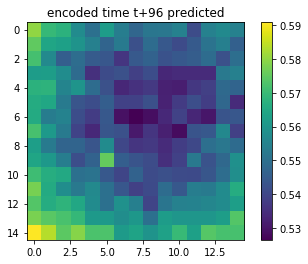

torch.Size([500, 1, 15, 15])


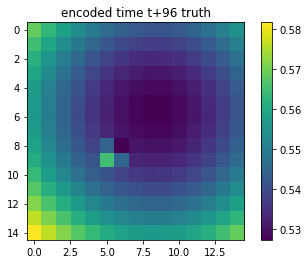

torch.Size([100, 500, 15, 15])
torch.Size([100, 499, 15, 15])


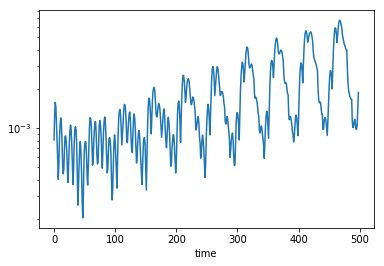

torch.Size([100, 499, 15, 15])
torch.Size([100, 499, 15, 15])


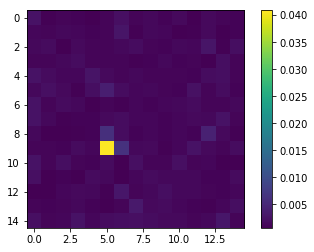

In [43]:
plt.imshow(encoded_t1_val[0,96])#, vmin=0.4, vmax=0.6)
plt.colorbar()
plt.title("encoded time t+96 predicted")
plt.show()

print(encoded.shape)
plt.imshow(val_encoded[0,97].cpu().detach().numpy())#, vmin=0.4, vmax=0.6)
plt.title("encoded time t+96 truth")
plt.colorbar()
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15)).shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15))[:,1:].shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,1))
plt.imshow(mse)
plt.colorbar()
plt.show()

12.0

In [ ]:
# # trained models at different levels
# models_space = {}
# print('model names: model_L{level}_{index}')
# for file_name in sorted(os.listdir(model_path)):
#     model_name, _ = file_name.split('.')
#     print(model_name)
#     models_space[model_name] = torch.load(os.path.join(model_path, file_name))

In [23]:
# model = models['model_L0_0']
# print(encoded_t1.shape)
# decoded = decode(model, encoded_t1,0)

# #decode the data 
model = models_space['model_L0_0']
print(encoded_t1_train.shape)
n_train, n_timesteps, _,_ = train_data.shape
train_decoded = torch.zeros((n_train, n_timesteps-1, 31,31))
val_decoded = torch.zeros((len(val_data), n_timesteps-1, 31,31))
data = encoded_t1_train.unsqueeze(2).float().to(device)
for i in tqdm(range(len(train_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    print(decoded.shape)
#     print(train_encoded.shape)
#     print(encoded.shape)
    train_decoded[i] = decoded[:,0]

# data = torch.tensor(val_data).unsqueeze(2).float()
data = encoded_t1_val.unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    val_decoded[i] = decoded[:,0]
    

torch.Size([500, 499, 15, 15])


  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([49

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([49

  0%|          | 0/100 [00:00<?, ?it/s]

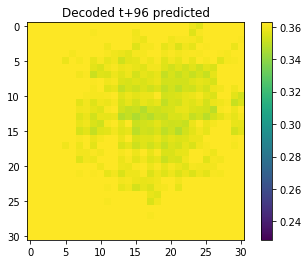

torch.Size([500, 1, 127, 127])


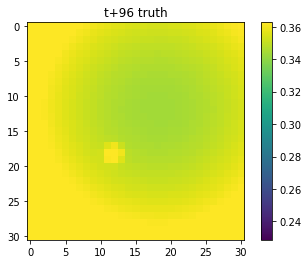

torch.Size([100, 500, 31, 31])
torch.Size([100, 499, 31, 31])


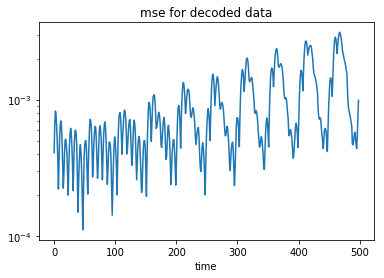

In [44]:
vmin = torch.min(val_decoded[0,0])
vmax = torch.max(val_decoded[0,0])

plt.imshow(val_decoded[0,96].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.title("Decoded t+96 predicted")
plt.colorbar()
plt.show()

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.imshow(val_data_layer0[0,97].cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("t+96 truth")
plt.show()

# print(train_decoded[0].shape)
# print(data_this[1:,0].shape)

print(val_data_layer0.shape)
print(val_decoded.shape)
mse = np.mean(((val_decoded.cpu() - val_data_layer0[:,1:].cpu())**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.title("mse for decoded data")
plt.show()

In [ ]:
plt.plot(val_data_layer0[0,:,18,12])
plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())

In [ ]:
class MultiScaleDynamicsDataSet():
    def __init__(self, train_data, val_data, train_data_output, val_data_output, n_levels, map_path=None, train_ratio=0.7, valid_ratio=0.2):
        # load data
#         data = np.load(data_path)
#         self.data = torch.tensor(data).unsqueeze(1).float()
#         #
#         if map_path is not None:
#             map_data = 1 - np.load(map_path)
#             self.map_data = torch.tensor(map_data).float()
#         else:
        

        self.nt, self.nx, self.ny = train_data.shape
        # partition
        indices = np.arange(self.nt)
        np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.map_data = self.map_data.to(self.device)
        
        self.data = torch.tensor(train_data).unsqueeze(1).float().to('cuda') 
        self.map_data = torch.ones(self.data.shape[-2:]).float().to('cuda')
        self.train_data = torch.tensor(train_data).unsqueeze(1).float() 
        self.val_data = torch.tensor(val_data).unsqueeze(1).float() 
        
        self.train_data_output = torch.tensor(train_data_output).unsqueeze(1).float() 
        self.val_data_output = torch.tensor(val_data_output).unsqueeze(1).float() 
        

    def obtain_data_at_current_level(self, level):
        train_data = self.train_data#self.data[self.train_inds].to(self.device)
        val_data = self.val_data#self.data[self.val_inds].to(self.device)
        test_data = self.val_data#self.data[self.test_inds].to(self.device)

        for _ in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data
    
    def obtain_data_at_current_level_output(self, level):
        train_data = self.train_data_output#self.data[self.train_inds].to(self.device)
        val_data = self.val_data_output#self.data[self.val_inds].to(self.device)
        test_data = self.val_data_output#self.data[self.test_inds].to(self.device)

        for _ in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data


In [ ]:
def train_arch(self, dataset, max_epoch, batch_size,
                   tol=None, lr=1e-3, w=0.5, verbose=1):
        """
        :param dataset: a MultiScaleDynamicsDataSet object
        :param max_epoch: maximum number of epochs
        :param batch_size: batch size
        :param tol: error tolerance (default is None)
        :param lr: learning rate
        :param w: w: loss = w * l2_loss + (1-w) * l_inf_loss
        :param verbose: verbose level
        :return: a list of train_losses, val_losses and timings
        """
        # prepare data at this level
        train_data, val_data, _ = dataset.obtain_data_at_current_level(self.cur_level)
        output_train, output_val = dataset.obtain_data_at_current_level_output(self.cur_level)

        # specify optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, eps=1e-3, weight_decay=1e-5)
        criterion = torch.nn.MSELoss(reduction='none')

        # collectors
        val_losses = list()
        train_losses = list()
        max_pos_set = set()

        # training
        epoch = 0
        ave_loss_old = 1e+10
        best_local_val_err = 1e+10
        best_state_dict = self.state_dict()
        while epoch < max_epoch:
            epoch += 1
            # =================== forward =====================
            new_idxs = torch.randperm(dataset.n_train)
            batch_idxs = new_idxs[:batch_size]
            batch_train_data = train_data[batch_idxs, :, :, :]
            output, _, _, _ = self.forward(batch_train_data, self.cur_level)
            output_val, _, _, _ = self.forward(val_data, self.cur_level)
            # =============== calculate losses ================
            mean_loss_train = criterion(output, batch_train_data).mean()
            max_loss_train = criterion(output, batch_train_data).mean(0).max()
            assert 0 <= w <= 1, print('w should between 0 and 1 (inclusive)!')
            loss = w * mean_loss_train + (1 - w) * max_loss_train
            mean_loss_val = criterion(output_val, val_data).mean()
            max_loss_val = criterion(output_val, val_data).mean(0).max()
            loss_val = w * mean_loss_val + (1 - w) * max_loss_val
            if loss_val.item() < best_local_val_err:
                best_local_val_err = loss_val.item()
                best_state_dict = self.state_dict()
            # compute global scale losses
            global_mean_loss, global_max_loss, _ = self.compute_global_loss(dataset, output, self.cur_level, dataset.train_inds[batch_idxs])
            global_mean_val_loss, global_max_val_loss, tup = self.compute_global_loss(dataset, output_val, self.cur_level, dataset.val_inds)
            global_loss = w * global_mean_loss + (1-w) * global_max_loss
            global_val_loss = w * global_mean_val_loss + (1-w) * global_max_val_loss
            # =================== backward ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ================= collect stat ==================
            train_losses.append(global_loss.item())
            val_losses.append(global_val_loss.item())
            max_pos_set.add(tup)
            # =================== log =========================
            # 1st epoch
            if epoch == 1 and verbose:
                # init err
                print('losses printing format: local: mse/max/overall, global: mse/max/overall')
                print('epoch [1/{}]'.format(max_epoch))
                print('[training set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_train.item(), max_loss_train.item(), loss.item(), global_mean_loss.item(), global_max_loss.item(), global_loss.item()))
                print('[validation set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_val.item(), max_loss_val.item(), loss_val.item(), global_mean_val_loss.item(), global_max_val_loss.item(), global_val_loss.item()))
            # every 1/10 max_epoch
            if epoch % (max_epoch // 10) == 0:
                print('epoch [{}/{}]:'.format(epoch, max_epoch))
                print('[training set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_train.item(), max_loss_train.item(), loss.item(), global_mean_loss.item(), global_max_loss.item(), global_loss.item()))
                print('[validation set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_val.item(), max_loss_val.item(), loss_val.item(), global_mean_val_loss.item(), global_max_val_loss.item(), global_val_loss.item()))
                # check for early stopping
                if tol is not None:
                    # check if fully resolved?
                    train_output, _, _, _ = self.forward(train_data, self.cur_level)
                    fully_resolved, _, _ = check_pixel_level_loss(train_data, train_output, tol=tol, device=self.device, w=0.5)
                    if fully_resolved and epoch < max_epoch:
                        print('early stopping at {}th iteration due to satisfying reconstruction!'.format(epoch))
                        break
                if epoch > max_epoch // 2 and epoch < max_epoch:
                    ave_loss = np.mean(train_losses[-(max_epoch // 10):])
                    if (ave_loss_old - ave_loss) / ave_loss_old < 1e-3:
                        # improvement is so small that we consider it as convergence
                        print('early stopping at {}th iteration due to slow convergence!'.format(epoch))
                        break
                    ave_loss_old = ave_loss

        # calculate the best validation error
        self.load_state_dict(best_state_dict)
        output_val, _, _, _ = self.forward(val_data, self.cur_level)
        global_mean_val_loss, global_max_val_loss, _ = self.compute_global_loss(dataset, output_val, self.cur_level, dataset.val_inds)
        global_val_loss = w * global_mean_val_loss + (1-w) * global_max_val_loss
        best_val_loss = global_val_loss.item()
        # check this level is clear if tolerance threshold is enabled
        filter_index = self.n_filter_groups_each_level[str(self.cur_level)] - 1
        train_output, _, _, _ = self.forward(train_data, self.cur_level)
        if tol is not None:
            _, _, resolved_map = check_pixel_level_loss(train_data, train_output, tol=tol, device=self.device, w=0.5)
            self.resolved_maps[str(self.cur_level)][str(filter_index)] = resolved_map.float()
            if resolved_map.all():
                self.level_clear[str(self.cur_level)] = True

        return self, val_losses, best_val_loss, max_pos_set

In [ ]:
#for next layer, we are going to have val_decoded as input and val_data_layer0 as output

print(train_decoded[:,0].shape)
print(val_decoded[:,0].shape)
dataset = MultiScaleDynamicsDataSet(train_decoded[:,0].to('cuda'), val_decoded[:,0].to('cuda'), 
                                    train_data_layer0[:,0].to('cuda'), val_data_layer0[:,0].to('cuda'), n_levels=1)

# # training in space
archs = [[1]]#,3,4],[1,2,3,4],[1,3,5,7]]
tols = [ 0.001]#, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)


In [ ]:
#load all models (don't actually need all of them)

# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))
    

In [ ]:
model = models_space['model_L0_0']

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)

print(train_decoded[:,0:1].shape)
forwarded,_,_,_ = model.forward(train_decoded[0].unsqueeze(1).to('cuda'), 0)

In [ ]:
print(forwarded.shape)

plt.imshow(forwarded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(train_decoded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
plt.plot(forwarded[:,0,0,0].cpu().detach().numpy())
plt.plot(train_decoded[0,:,0,0].cpu().detach().numpy())
# plt.colorbar()
plt.show()

In [ ]:
# plt.plot(val_decoded[0,:,12,18].cpu().detach().numpy())
# plt.plot(val_data_layer0[0,1:,12,18].cpu().detach().numpy())

plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())
plt.plot(val_data_layer0[0,1:,18,12].cpu().detach().numpy())
plt.show()

plt.imshow(val_data_layer0[0,0])
plt.colorbar()


In [ ]:
plt.plot(train_decoded[0,:,12,18].cpu().detach().numpy())
print(train_decoded.shape)
print(data_this.shape)
data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.plot(data_this[:,0, 12, 18].cpu().detach().numpy())

In [ ]:
#animate the first decoded

def animate(snapshots, normalize = True, file_name = "animation.gif"):
    """
    Makes an animation of snapshots in time
    
    inputs:
    snapshots: np.array of size (n_time_steps,1, dim, dim)
    normalize = True: whether to fix axis between 0 and 1 or not
    file_name = "animation.gif": file name of where to save gif
    
    outputs:
    no returned output
    gif saved to file_name
    """


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    if normalize:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0.0, vmax=1.0)
    else:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()

    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig,
                                   animate_func,
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)

    print('Done! gif saved to ', file_name)
    
to_animate = val_decoded[0].unsqueeze(1).cpu().detach().numpy()
animate(to_animate, False, 'decoded_0_0.gif')

In [ ]:
val_decoded[0].unsqueeze(1).shape